In [ ]:
%matplotlib inline


# Seasonal Tilt

Example of a custom Mount class.


Some PV systems are built with the option to adjust the module
tilt to follow seasonal changes in solar position.  For example,
SAM calls this strategy "Seasonal Tilt".  This example shows how
to use a custom Mount class to use the Seasonal Tilt strategy
with :py:class:`~pvlib.modelchain.ModelChain`.



In [1]:
import pvlib
from pvlib import pvsystem, location, modelchain, iotools
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from dataclasses import dataclass

New Mount classes should extend ``pvlib.pvsystem.AbstractMount``
and must implement a ``get_orientation(solar_zenith, solar_azimuth)`` method:



In [2]:
@dataclass
class SeasonalTiltMount(pvsystem.AbstractMount):
    monthly_tilts: list  # length 12, one tilt per calendar month
    surface_azimuth: float = 180.0

    def get_orientation(self, solar_zenith, solar_azimuth):
        tilts = [self.monthly_tilts[m-1] for m in solar_zenith.index.month]
        return pd.DataFrame({
            'surface_tilt': tilts,
            'surface_azimuth': self.surface_azimuth,
        }, index=solar_zenith.index)

First let's grab some weather data and make sure our mount produces tilts
like we expect:



/usr/local/lib/python3.11/site-packages/pvlib/iotools/tmy.py:247: pvlibDeprecationWarning: TMY3 variable names will be renamed to pvlib conventions by default starting in pvlib 0.11.0. Specify map_variables=True to enable that behavior now, or specify map_variables=False to hide this warning.
  warnings.warn(


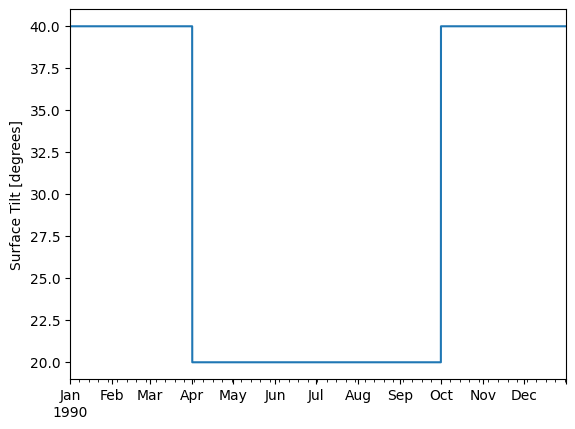

In [3]:
DATA_DIR = pathlib.Path(pvlib.__file__).parent / 'data'
tmy, metadata = iotools.read_tmy3(DATA_DIR / '723170TYA.CSV', coerce_year=1990)
# shift from TMY3 right-labeled index to left-labeled index:
tmy.index = tmy.index - pd.Timedelta(hours=1)
weather = pd.DataFrame({
    'ghi': tmy['GHI'], 'dhi': tmy['DHI'], 'dni': tmy['DNI'],
    'temp_air': tmy['DryBulb'], 'wind_speed': tmy['Wspd'],
})
loc = location.Location.from_tmy(metadata)
solpos = loc.get_solarposition(weather.index)
# same default monthly tilts as SAM:
tilts = [40, 40, 40, 20, 20, 20, 20, 20, 20, 40, 40, 40]
mount = SeasonalTiltMount(monthly_tilts=tilts)
orientation = mount.get_orientation(solpos.apparent_zenith, solpos.azimuth)
orientation['surface_tilt'].plot()
plt.ylabel('Surface Tilt [degrees]')
plt.show()

With our custom tilt strategy defined, we can create the corresponding
Array and PVSystem, and then run a ModelChain as usual:



In [4]:
module_parameters = {'pdc0': 1, 'gamma_pdc': -0.004, 'b': 0.05}
temp_params = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
array = pvsystem.Array(mount=mount, module_parameters=module_parameters,
                       temperature_model_parameters=temp_params)
system = pvsystem.PVSystem(arrays=[array], inverter_parameters={'pdc0': 1})
mc = modelchain.ModelChain(system, loc, spectral_model='no_loss')

_ = mc.run_model(weather)

Now let's re-run the simulation assuming tilt=30 for the entire year:



In [5]:
array2 = pvsystem.Array(mount=pvsystem.FixedMount(30, 180),
                        module_parameters=module_parameters,
                        temperature_model_parameters=temp_params)
system2 = pvsystem.PVSystem(arrays=[array2], inverter_parameters={'pdc0': 1})
mc2 = modelchain.ModelChain(system2, loc, spectral_model='no_loss')
_ = mc2.run_model(weather)

And finally, compare simulated monthly generation between the two tilt
strategies:



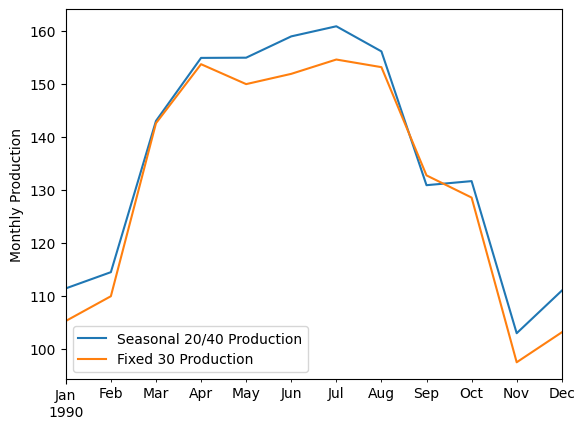

In [6]:
# sphinx_gallery_thumbnail_number = 2
results = pd.DataFrame({
    'Seasonal 20/40 Production': mc.results.ac,
    'Fixed 30 Production': mc2.results.ac,
})
results.resample('m').sum().plot()
plt.ylabel('Monthly Production')
plt.show()